In [25]:
import sys
sys.executable
import torch
import pytorch_lightning as pl
import tensorflow as tf
import tensorboard as tb
print(torch.__version__)
print(pl.__version__)
import torch
print(torch.cuda.is_available())
#check GPU 

1.11.0+cu113
1.7.0
True


In [26]:
import pandas as pd
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
import numpy as np
import torchmetrics
import torch
import pytorch_forecasting.metrics as metrics
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import CrossEntropy,QuantileLoss
import torch.nn as nn

# switch data by #
data = pd.read_csv('NVDA-5y.csv')
# data = pd.read_csv('AAPL-5y.csv')
# data = pd.read_csv('TSLA-5y.csv')

# data = pd.read_csv('NVDA_data.csv')
# data = pd.read_csv('NVDA-AI.csv')


data['Date'] = pd.to_datetime(data['Date'])
data['time_idx'] = data.index
data['group_ids']=0

# Extracting time series data
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(str)
data['Day'] = pd.to_datetime(data['Date']).dt.day.astype(str)

In [4]:
import torch.nn.functional as F
# Define drop_lenth and encoder_length here
drop_lenth = 0
data = data.head(len(data) - drop_lenth)
max_encoder_length = 600


test_length= 5
max_prediction_length = 5 
test_cutoff = data["time_idx"].max() - test_length  # Calculate the cutoff point for the test set
used_data = data[data["time_idx"] <= test_cutoff]  
test_data = data[data["time_idx"] > test_cutoff]

training_cutoff = used_data['time_idx'].max() - max_prediction_length # Calculate the cutoff point for the validation set
used_data = data[data["time_idx"] <= test_cutoff]  
training = used_data[used_data['time_idx'] <= training_cutoff]
validation = used_data[used_data['time_idx'] > training_cutoff]

print(used_data[used_data['time_idx'] == used_data['time_idx'].max()])#check data

           Date        Open        High         Low   Close  Adj Close  \
1252 2024-07-19  120.349998  121.599998  117.370003  117.93     117.93   

         Volume  time_idx  group_ids  Year Month Day  
1252  217223800      1252          0  2024     7  19  


In [5]:
# Construct training set & val set & test set
training_dataset = TimeSeriesDataSet(
    used_data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    # switch data and use different features is needed:
    # static_reals=['AI'],
    # static_reals=['Revenue','Net Income','EPS','Operating Income','EBITDA','Current Ratio'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    used_data, 
    predict=True, 
    stop_randomization=True
)

used_dataset = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= test_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    # static_reals=['AI'],
    # static_reals=['Revenue','Net Income','EPS','Operating Income','EBITDA','Current Ratio'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)
test_dataset = TimeSeriesDataSet.from_dataset(
    used_dataset,  
    data, 
    predict=True, 
    stop_randomization=True 
)
# Structuring the data
batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

import random
pl.seed_everything(42)

# Redefine the loss function, this is just an example.
class CustomQuantileLoss(torchmetrics.Metric):
    def __init__(self, quantiles, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.quantiles = quantiles
        self.add_state("total_loss", default=torch.tensor(0.0), dist_reduce_fx="sum")
    
    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        loss = 0.0
        mse_loss = F.mse_loss(y_pred, y_true, reduction='mean')
        loss += mse_loss
        self.total_loss += loss
    
    def compute(self):
        return self.total_loss

quantiles = [0.1,0.2, 0.5,0.8,0.9] # Can be redefined quantiles
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.1,
    hidden_size=128,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=128,
    # output_size=1,
    loss = torchmetrics.MeanSquaredError(), # use mse
    log_interval=10,
    reduce_on_plateau_patience=4
)


Global seed set to 42
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [6]:
import tensorflow as tf
import tensorboard as tb
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning import Callback
import pytorch_lightning.loggers as pl_loggers
import logging
logging.basicConfig(level=logging.INFO)

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

optimizer = torch.optim.Adam(tft.parameters(), lr=0.01)# real lr here
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.5, 
                              patience=2, # If the loss does not decrease after 2 times, reduce the learning rate
                              verbose=True, 
                              min_lr=1e-6
                             )
lr_monitor = LearningRateMonitor(logging_interval='step')

# rewrite callback
class LRSchedulerCallback(Callback):
    def __init__(self, scheduler):
        self.scheduler = scheduler

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.scheduler.step(val_loss)
        
scheduler_callback = LRSchedulerCallback(scheduler)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=2,# Important parameters to prevent gradient explosion
    log_every_n_steps=1,
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=12, # Preventing Overfitting
                             mode='min',
                             verbose=True),
               lr_monitor,
               scheduler_callback,
               ModelCheckpoint(monitor='val_loss',
                               mode='min',
                               save_top_k=1, #save the best model
                               verbose=True)
              ],


)


trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 413   
3  | prescalers                         | ModuleDict                      | 3.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 200 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 614 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 271 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 4151.533
Epoch 0, global step 9: 'val_loss' reached 4151.53271 (best 4151.53271), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_145\\checkpoints\\epoch=0-step=9.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3946.883 >= min_delta = 0.0. New best score: 204.650
Epoch 1, global step 18: 'val_loss' reached 204.65007 (best 204.65007), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_145\\checkpoints\\epoch=1-step=18.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 27: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 185.854 >= min_delta = 0.0. New best score: 18.796
Epoch 3, global step 36: 'val_loss' reached 18.79580 (best 18.79580), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_145\\checkpoints\\epoch=3-step=36.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 45: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 54: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 63: 'val_loss' was not in top 1


Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 72: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 81: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 90: 'val_loss' was not in top 1


Epoch 00010: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 99: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 108: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 117: 'val_loss' was not in top 1


Epoch 00013: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 126: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 135: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 12 records. Best score: 18.796. Signaling Trainer to stop.
Epoch 15, global step 144: 'val_loss' was not in top 1


Epoch 00016: reducing learning rate of group 0 to 6.2500e-04.


In [7]:
# get best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# get prediction
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

# check mae
mae = (actuals - predictions).abs().mean()
print(f'VAL-MAE: {mae}')


VAL-MAE: 2.9101898670196533


6 : 6 

[119.27263, 127.837845, 118.96419, 121.37688, 115.28534] 
 [128.440002, 126.360001, 117.989998, 121.089996, 117.93]
Mean Absolute Error: 2.9101896324218757
Mean Absolute Percentage Error: 2.4382715596199804%
Root Mean Squared Error: 4.341666271716194
Spearman's rho (ρ): 0.7


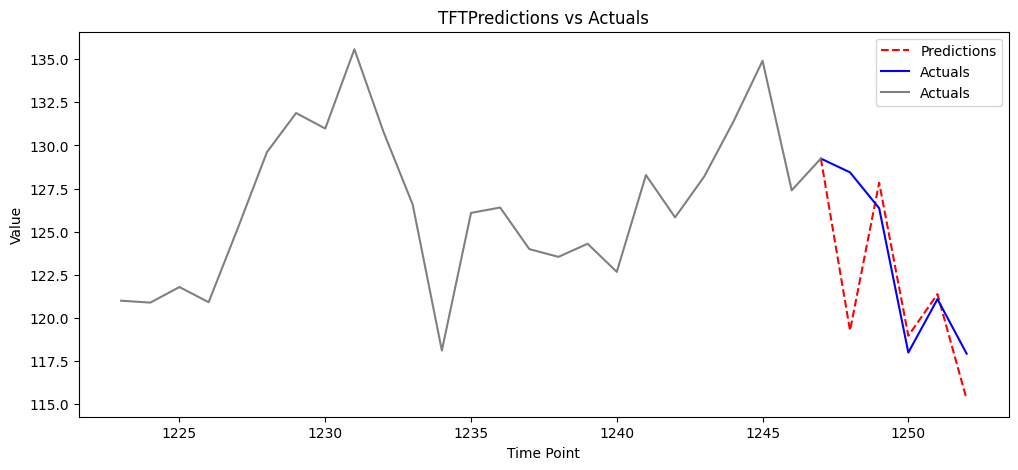

In [8]:
import matplotlib.pyplot as plt
import torch

# Here we refine the predicted values and display

predictions_np = predictions.numpy()
actuals_np = actuals.numpy()
validation1=validation['Close'].tolist()

data1 = used_data['Close']

last_historical_point = data1.iloc[-6]
forecast_predictions = predictions_np[0]
forecast_actuals = validation1

# Construct a new data sequence, putting the last historical point first in the predicted and actual points

predictions_np = [last_historical_point] + list(forecast_predictions)
validation1 = [last_historical_point] + list(forecast_actuals)

print(len(predictions_np),':',len(predictions_np),'\n')
print(predictions_np[1:],'\n', validation1[1:])

from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
time_points = np.arange(1, len(predictions_np) + 1)
mae = mean_absolute_error(predictions_np[1:], validation1[1:])

print(f'Mean Absolute Error: {mae}')
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(predictions_np[1:], validation1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(predictions_np[1:], validation1[1:]))
print(f'Root Mean Squared Error: {rmse}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(predictions_np[1:], validation1[1:])

print(f"Spearman's rho (ρ): {corr}")
plt.figure(figsize=(12, 5))


plt.plot(data1.index[-6:], predictions_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], validation1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
# plt.grid(True)
plt.show()

1


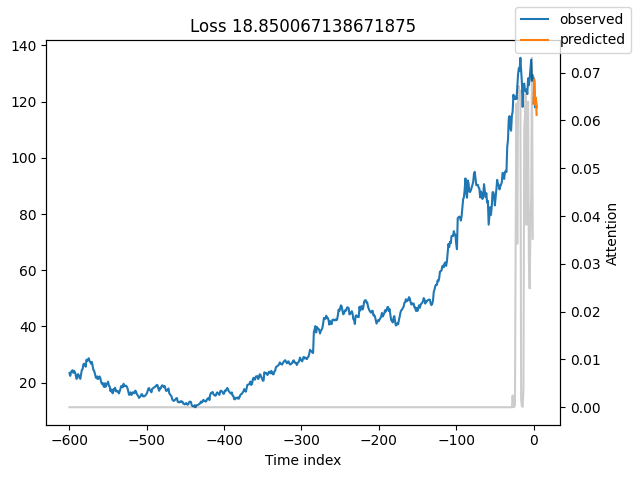

In [9]:
# View the last training process
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(len(raw_predictions['encoder_lengths']))
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x475 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

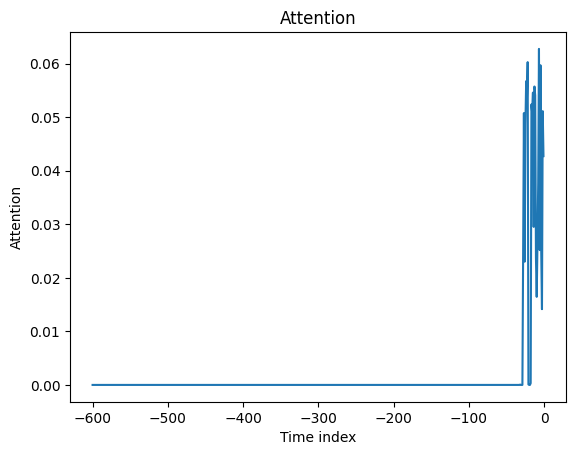

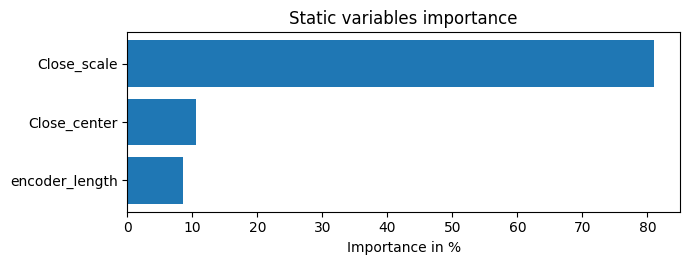

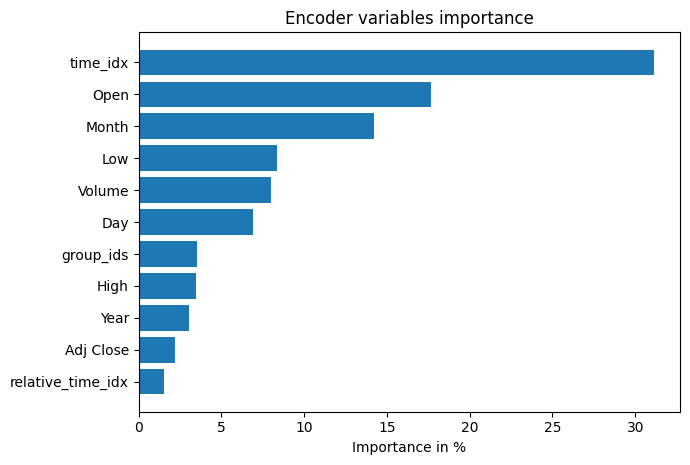

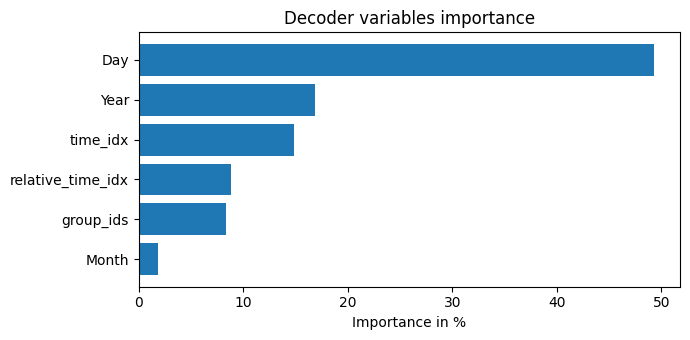

In [22]:
# View the interpretable information of the test set
raw_predictions, x = best_tft.predict(test_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [11]:
#save the model
torch.save(best_tft.state_dict(), 'TFT-model-weights.pth')

In [12]:
# Re-instantiate the model(It must be exactly the same as the model parameters to be read)
best_tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=128,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=128,
    # output_size=1,
    loss = 1*torchmetrics.MeanSquaredError(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

best_tft.load_state_dict(torch.load('TFT-model-weights.pth'))


C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<All keys matched successfully>

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Close_center': <Figure size 1000x500 with 2 Axes>,
 'Close_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'Year': <Figure size 1000x500 with 2 Axes>,
 'group_ids': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Adj Close': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'Low': <Figure size 1000x500 with 2 Axes>,
 'Open': <Figure size 1000x500 with 2 Axes>,
 'High': <Figure size 1000x500 with 2 Axes>,
 'Month': <Figure size 1000x500 with 2 Axes>,
 'Day': <Figure size 1000x500 with 2 Axes>}

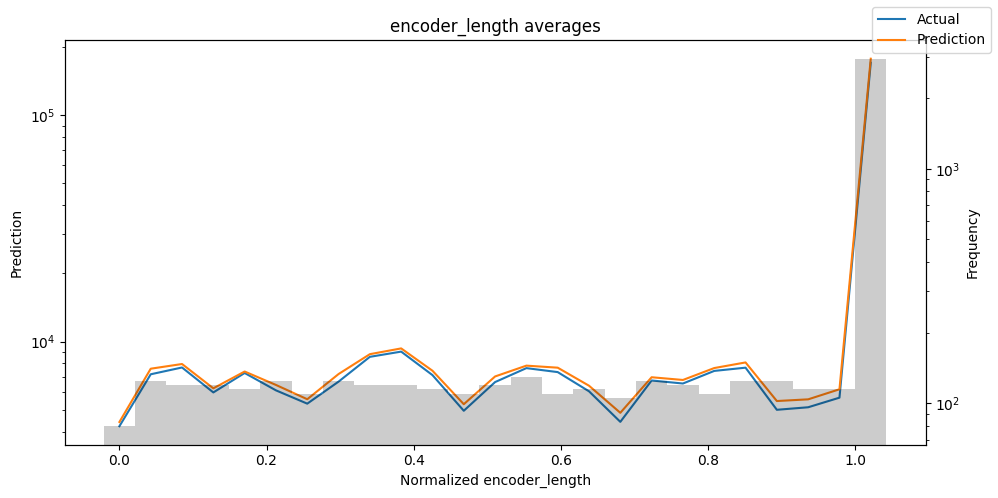

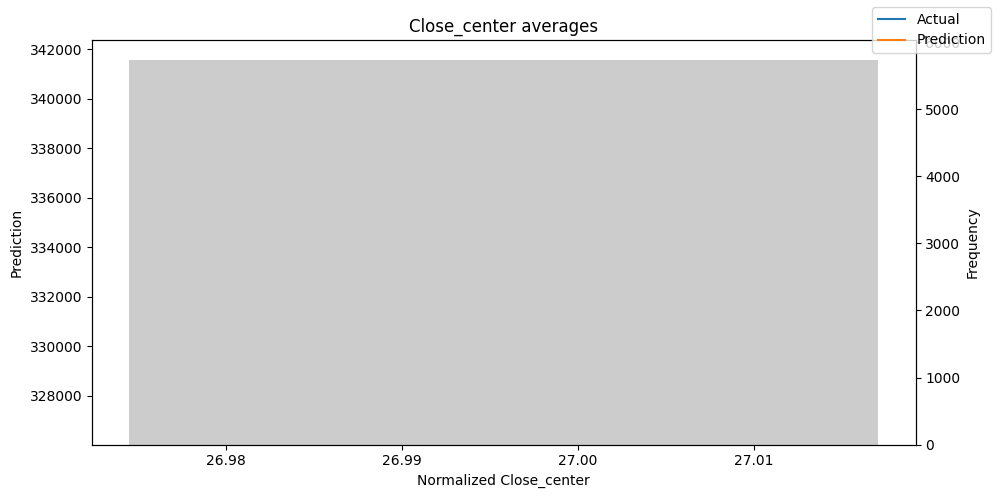

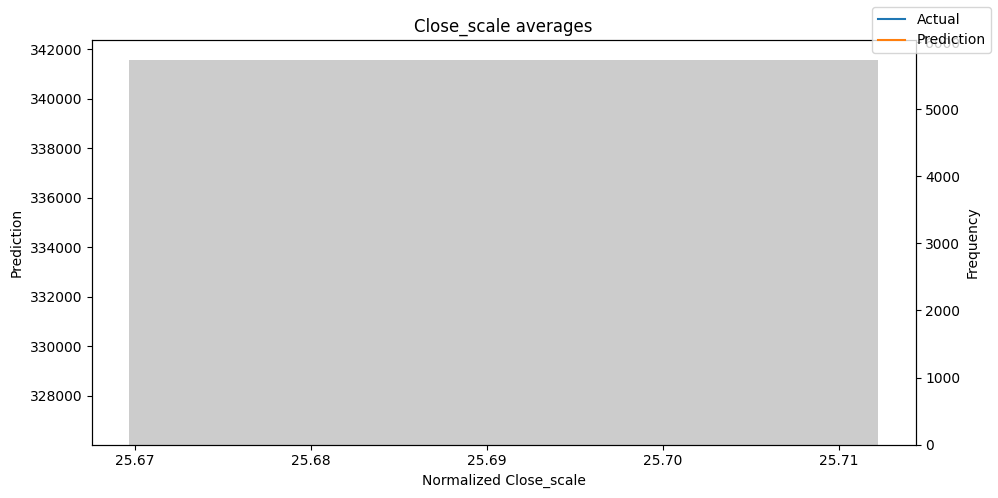

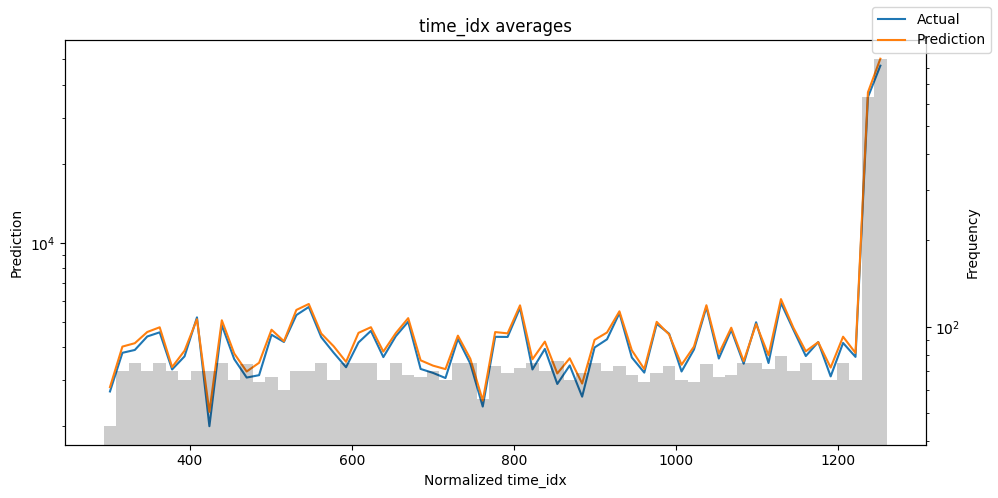

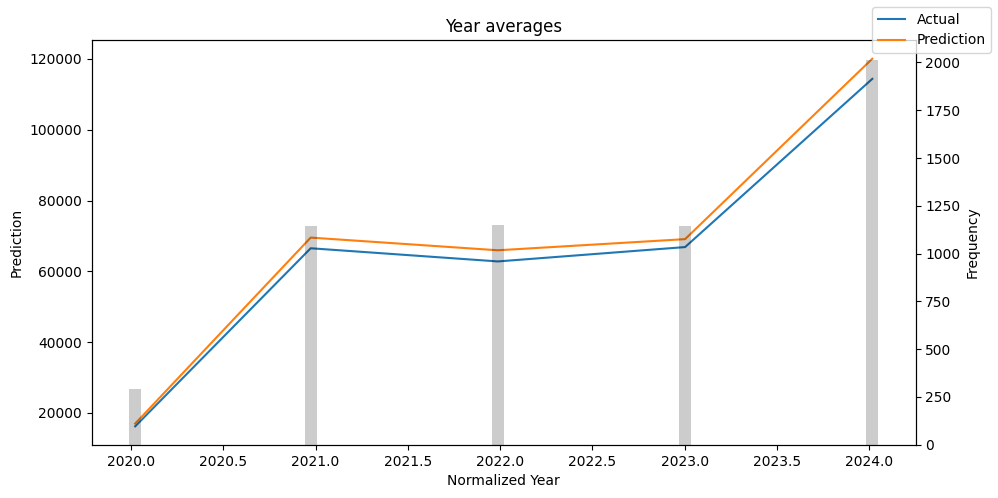

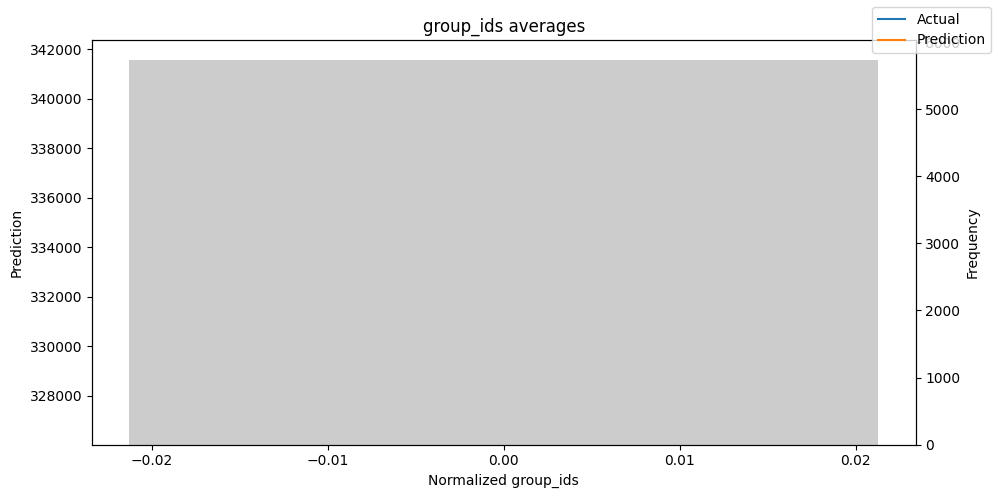

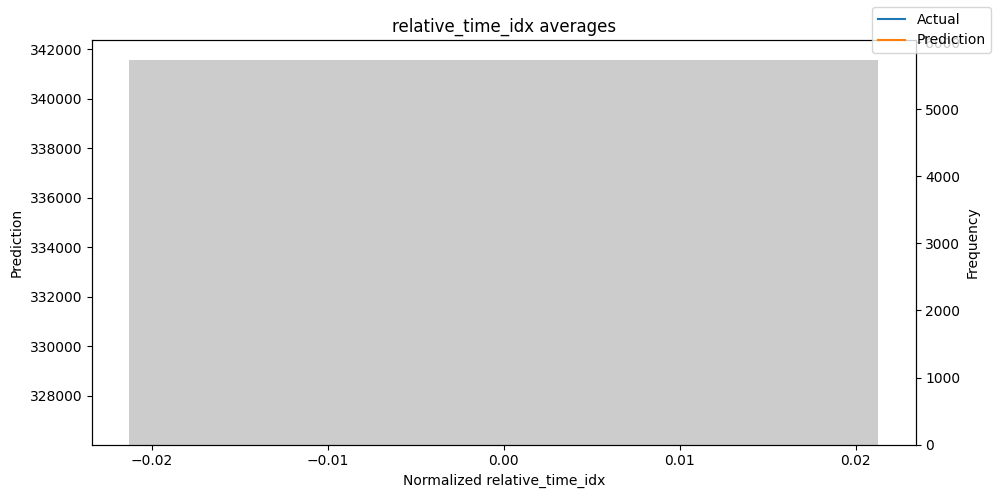

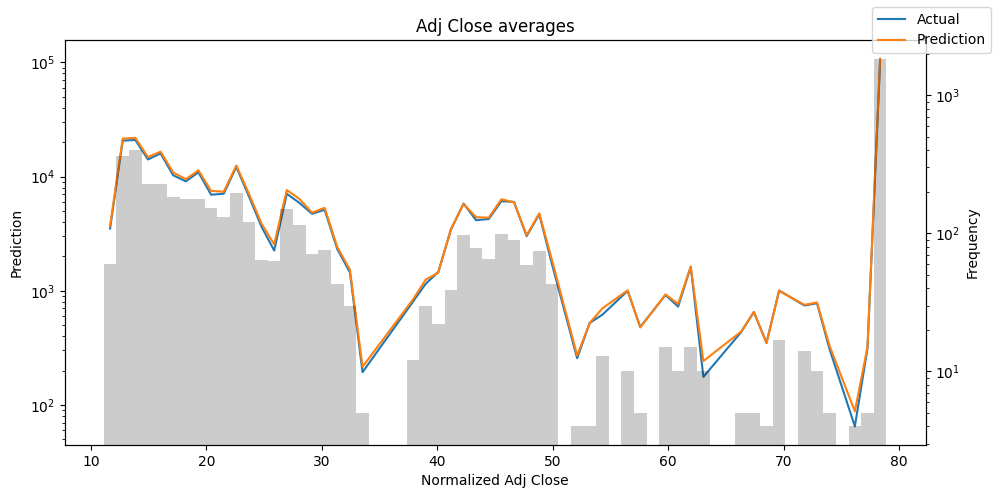

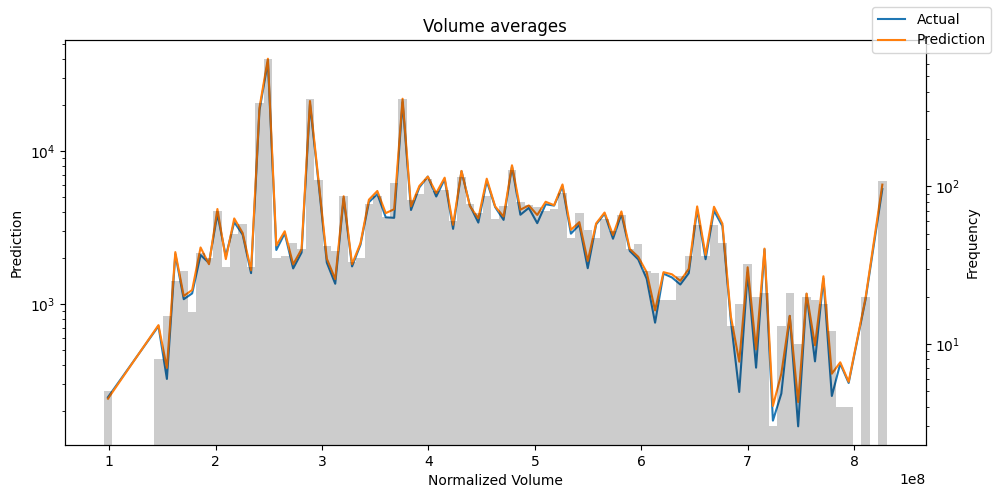

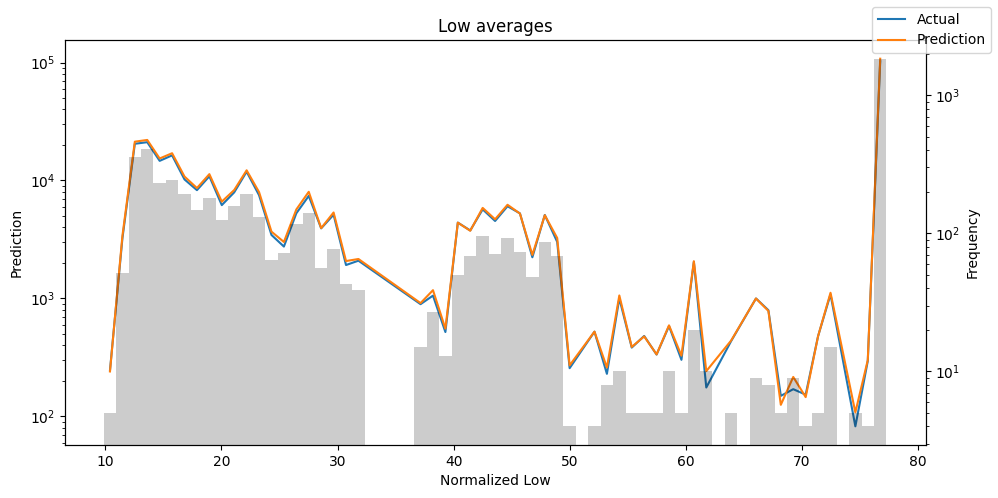

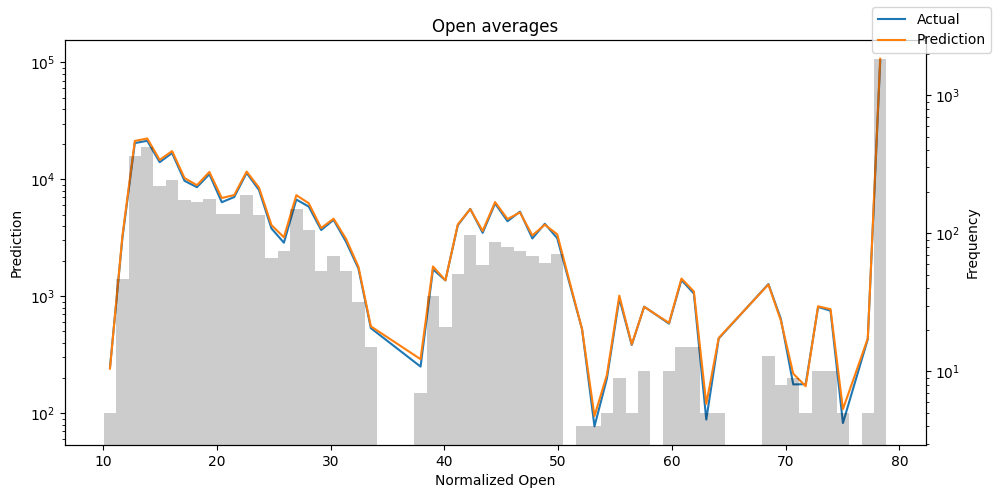

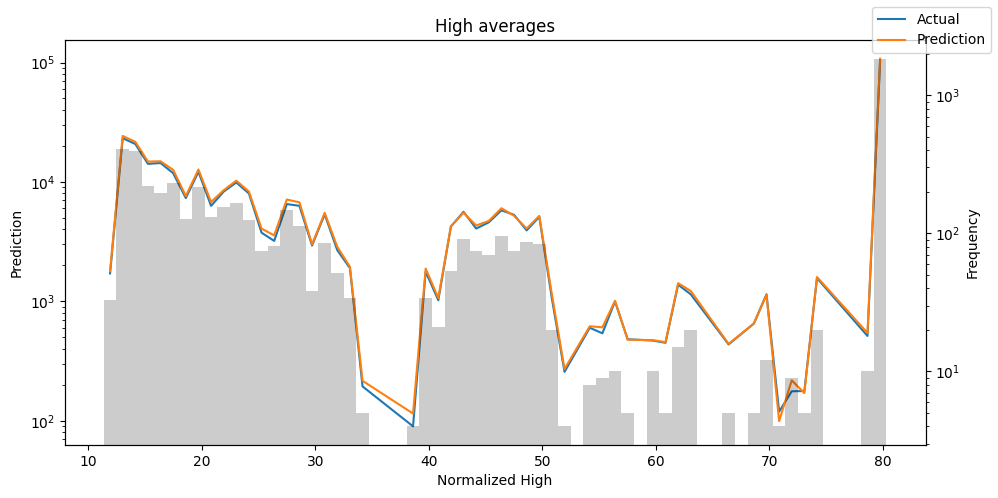

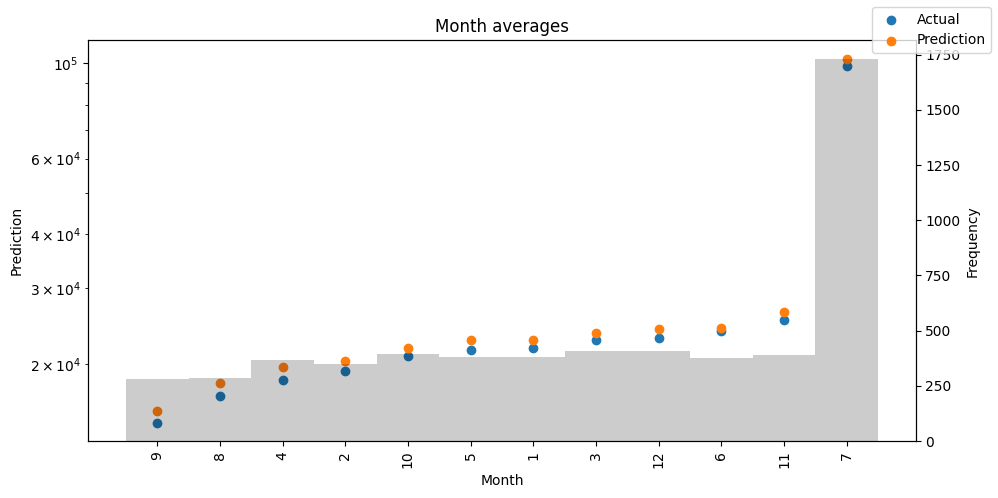

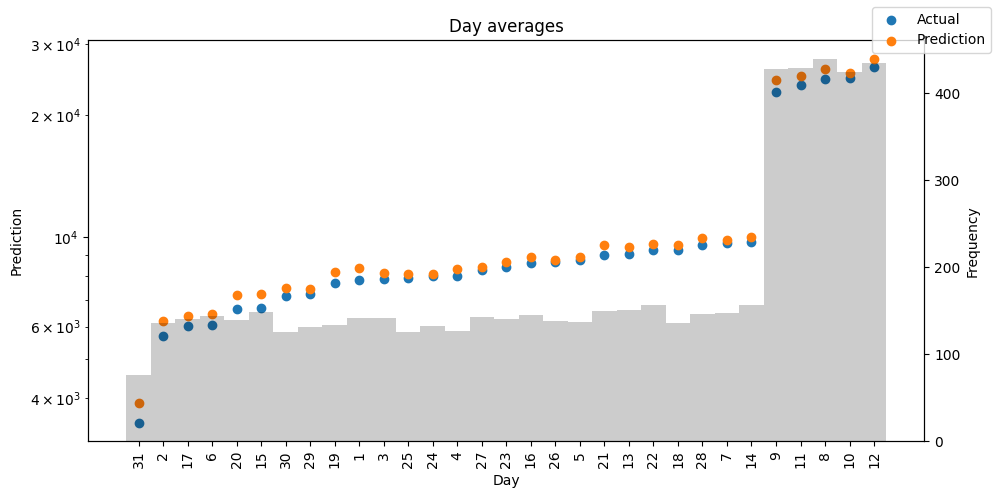

In [13]:
import numpy as np
# You can view the training details here
predictions,x = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions,normalize=False)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [14]:
# get prediction
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
test_results = best_tft.predict(test_dataloader)

mae = (test_actuals - test_results).abs().mean()

print(f'VAL-MAE: {mae}')


VAL-MAE: 9.57275104522705


Mean Absolute Percentage Error: 7.583499804045698%
Root Mean Squared Error: 9.938660355708198
Mean Absolute Error: 9.572750772753906
Spearman's rho (ρ): 0.8999999999999998
Spearman's p_value: 0.03738607346849874


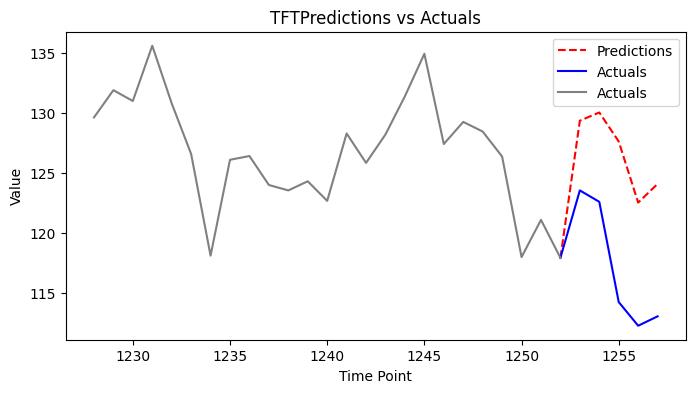

In [24]:
import matplotlib.pyplot as plt
import torch

test_results_np = test_results.numpy()
test_actuals_np = test_actuals.numpy()
test_data1=test_data['Close'].tolist()

data1 = data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = test_results_np[0]
forecast_actuals = test_data1

# Construct a new data sequence, putting the last historical point first in the predicted and actual points(to show)
test_results_np = [last_historical_point] + list(forecast_predictions)
test_data1 = [last_historical_point] + list(forecast_actuals)

from sklearn.metrics import mean_absolute_error
import numpy as np
time_points = np.arange(1, len(predictions_np) + 1)
mae = mean_absolute_error(test_results_np[1:], test_data1[1:])

mape = mean_absolute_percentage_error(test_results_np[1:], test_data1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(test_results_np[1:], test_data1[1:]))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_results_np[1:], test_data1[1:])

print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")

plt.figure(figsize=(8, 4))
plt.plot(data1.index[-6:], test_results_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], test_data1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')

plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

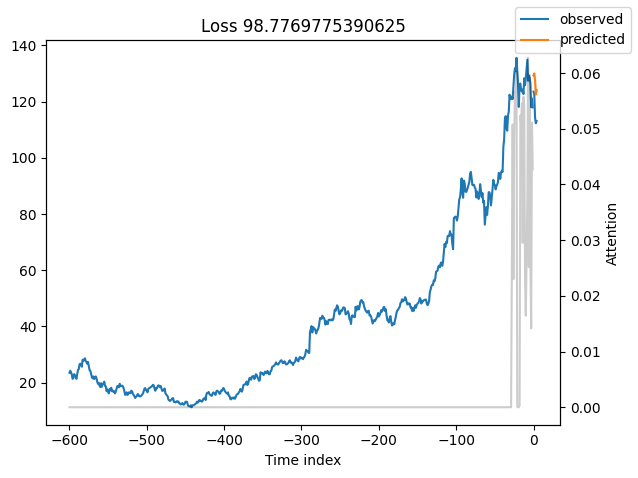

In [17]:
test_raw_predictions, test_x = best_tft.predict(test_dataloader, mode="raw", return_x=True)
best_tft.plot_prediction(test_x, test_raw_predictions, idx=0, add_loss_to_title=True);

In [19]:
# ################
# In this column, the model can find the best parameters, but the effect is not good. 
# This is very time-consuming
# It has been executed twice.
# The report generated by optimize_hyperparameters() can be found in the root directory.



# import pickle
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters        
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test/optimize_hyperparameters",
#     n_trials=100,
#     max_epochs=40,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.0001, 0.01),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs = {
#         'limit_train_batches': 30,
#         'accelerator': 'gpu',
#         'devices': [0],
#         'log_every_n_steps': 1
#     },
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
#     verbose=1,
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)